# Setup libraries

In [84]:
import spacy
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
%matplotlib notebook

# Setup important variables

In [85]:
subsample = 100 # Use a subsample of the data
nlp = spacy.load('en')
path_inputs = os.path.join('data', 'cases')
path_labels = os.path.join('data')
filenames = random.sample([filename for filename in os.listdir(path_inputs)], subsample)

# Parse all documents once and store parsed versions

In [86]:
parsed_docs = []
for filename in filenames:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        parsed_docs.append(doc)

# Count the number of sentences, words and letters for each document

In [87]:
df = pd.DataFrame(columns=['Sentences', 'Words', 'Letters']).astype(np.int64)

for doc in parsed_docs:
    # Count
    sentences = len(list(doc.sents))
    words = 0
    letters = 0
    for token in doc:
        if not token.is_space and not token.is_punct:
            words += 1
            letters += len(token.text)
    # Add to dataframe
    new_entry = {'Sentences': sentences, 'Words': words, 'Letters': letters}
    df = df.append(new_entry, ignore_index=True)

# Histogram for the computed statistics

<IPython.core.display.Javascript object>


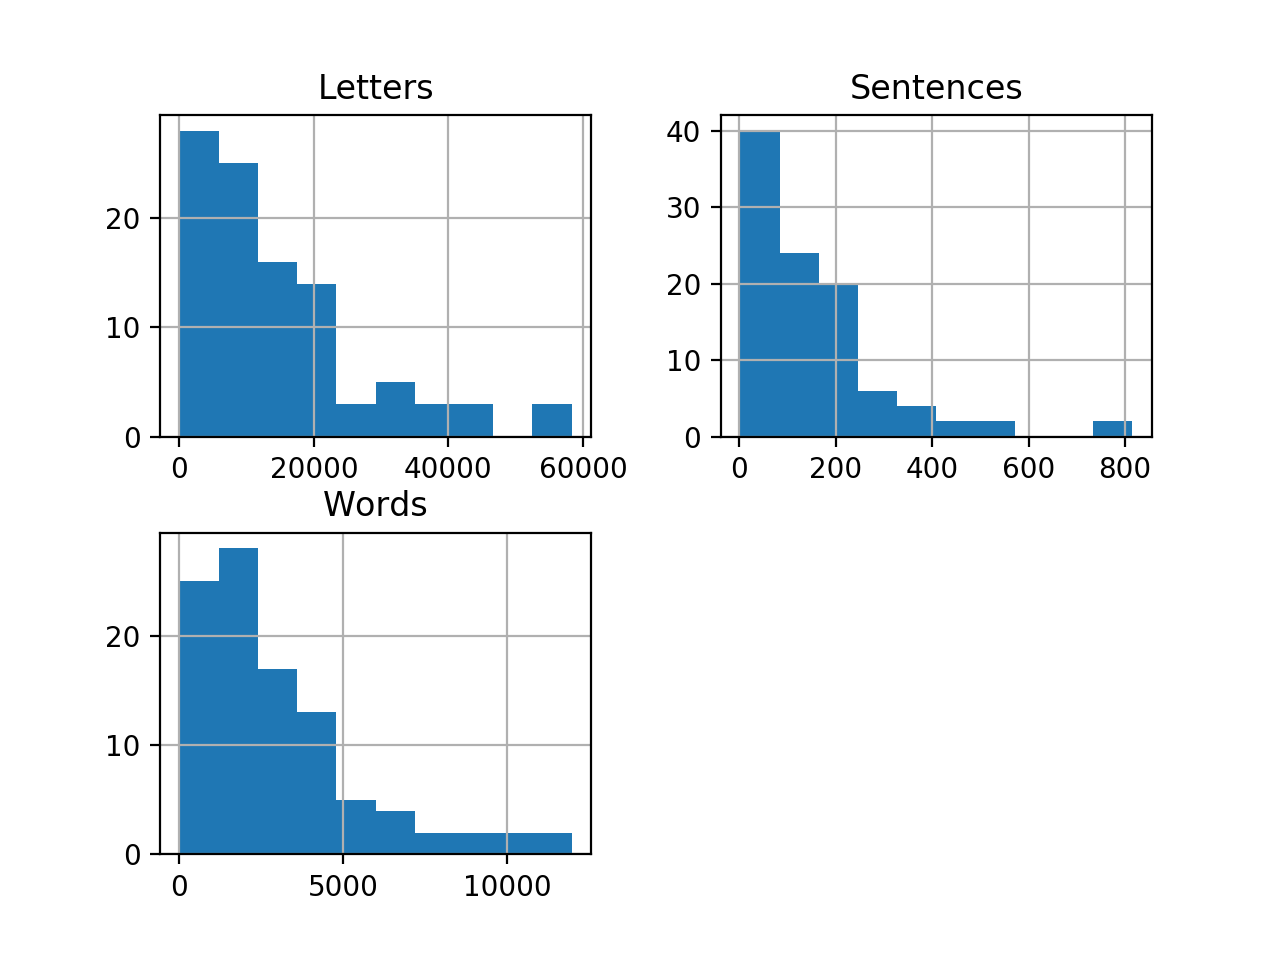

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a76de8080>,
      dtype=object)

In [88]:
df.hist()

# Count nouns, verbs, adjectives in each document

In [98]:
# first 4 letter of filenames is the year
years = list(set(([int(filename[:4]) for filename in filenames])))
dfPOS = pd.DataFrame(np.zeros((len(years), 3)), index=years, columns=['Nouns', 'Verbs', 'Adjectives']).astype(np.int64)
dfPOS.sort_index(inplace=True)

for filenameidx, doc in enumerate(parsed_docs):
    # Count
    nouns = 0
    adjectives = 0
    verbs = 0
    year = int(filenames[filenameidx][:4])
    for token in doc:
        if token.pos_ == 'VERB':
            verbs += 1
        elif token.pos_ == 'NOUN':
            nouns += 1
        elif token.pos_ == 'ADJ':
            adjectives += 1
    # Add to dataframe
    new_entry = dfPOS.loc[year]
    new_entry['Nouns'] += nouns
    new_entry['Adjectives'] += adjectives
    new_entry['Verbs'] += verbs
    dfPOS.loc[year] = new_entry

<IPython.core.display.Javascript object>


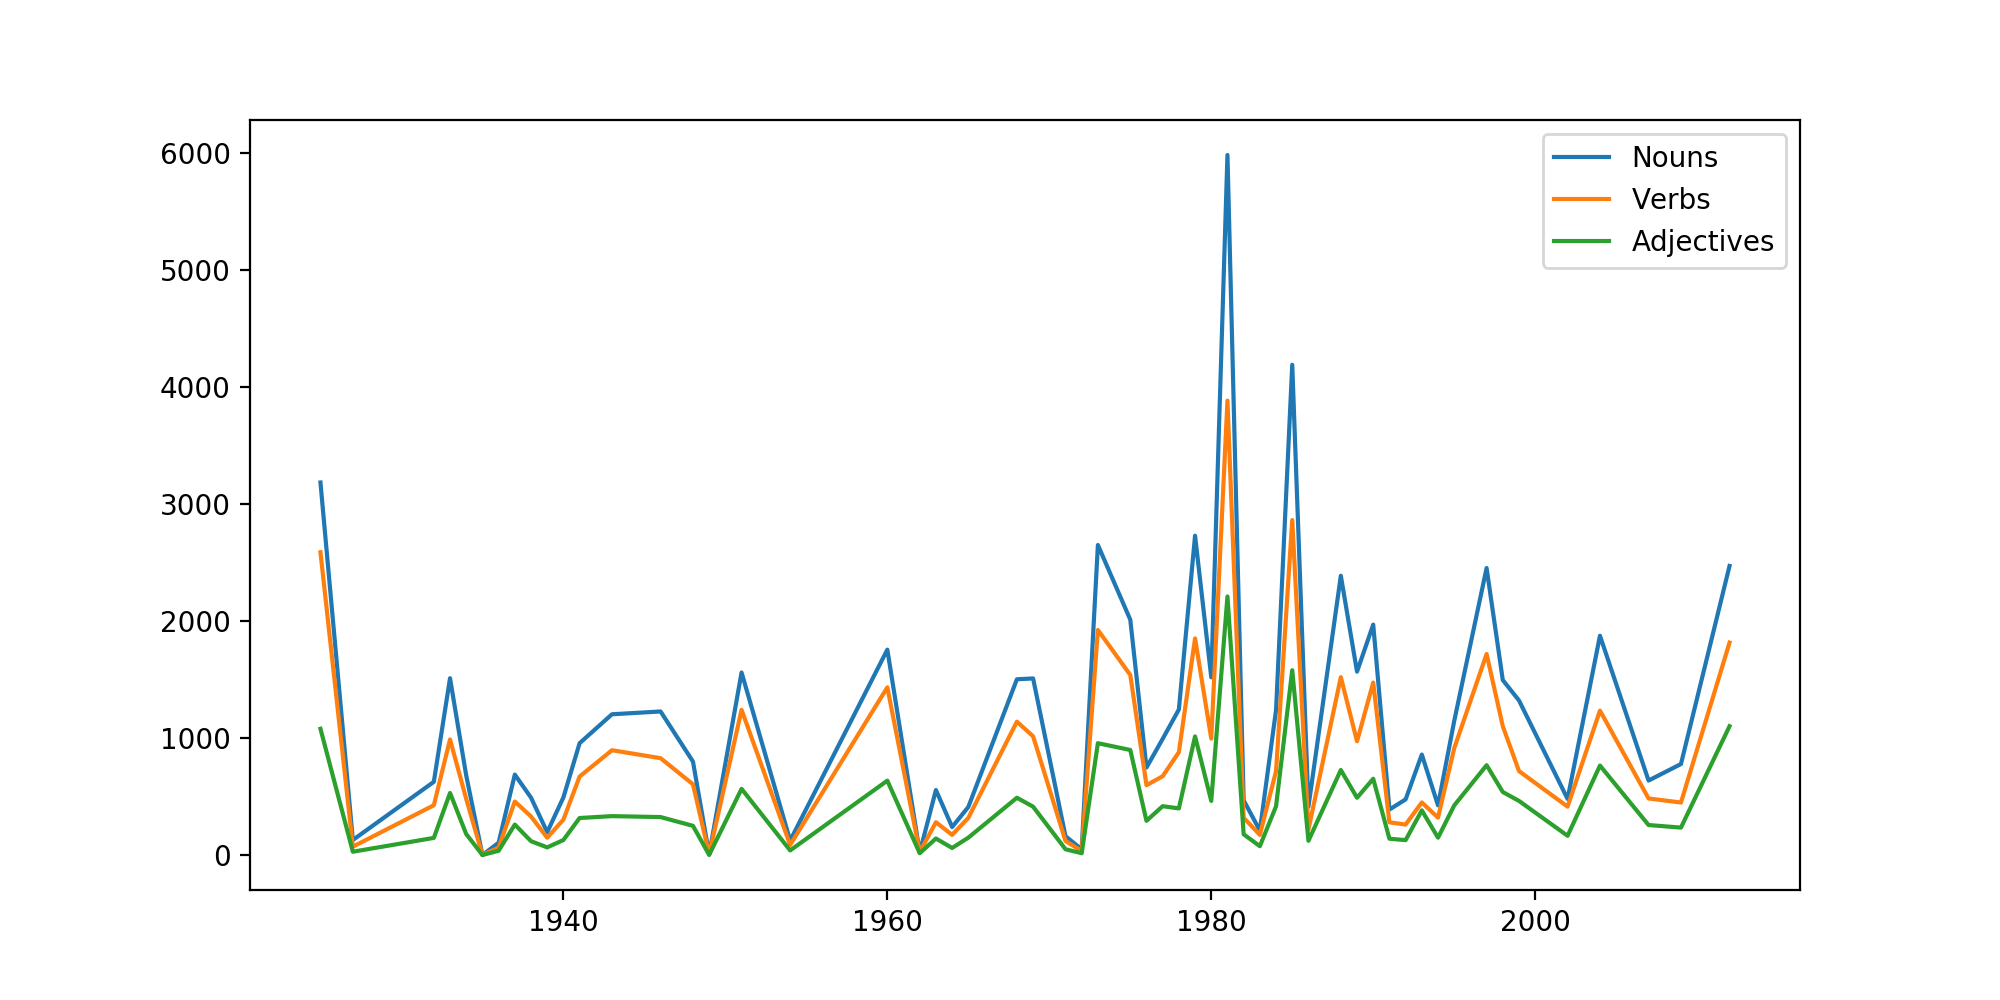

In [99]:
# Visualize POS frequency by year
dfPOS.plot(figsize=(10,5))

# Normalizing corpus

We remove punctuation as well as whitespace as they are not useful in creating trigrams.
We also remove stop words as they don't change the context we want to capture with trigrams.
We also use lemmatization to match different inflectional forms of the the same words without changing the part of speech of the word.

In [100]:
# Count occurences of each normalized trigram that ends in a noun
trigram_count = {}
# Indices
LEMMA = 0
POS = 1 # part-of-speech

for doc in parsed_docs:
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in trigram_count:
                trigram_count[trigram] += 1
            else:
                trigram_count[trigram] = 1

# Select top 1000 trigrams as features

In [101]:
TOP = 1000
# sort descending by the value(count) and select the first TOP as the features
top_trigrams, _ = map(list, zip(*(sorted(list(trigram_count.items()), key=lambda x: -x[1])[:TOP])))

# Create a dataframe using the 1000 trigram features for each document

In [103]:
# Extract case names
cases = sorted(list(([filename[5:-4] for filename in filenames])))

# Dataframe to hold counts for each trigram feature
dfTRI = pd.DataFrame(np.zeros((len(cases), len(top_trigrams))), index=cases, columns=top_trigrams).astype(np.int64)

for filenameidx, doc in enumerate(parsed_docs):
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in top_trigrams:
                dfTRI.at[filenames[filenameidx][5:-4], trigram] += 1
                

# Normalize the dataframe to have unit variance per feature
We keep me the mean as it is in order to maintain spasity

In [104]:
dfTRI_normalized = dfTRI / dfTRI.std()

# Load case_reversed.csv

In [105]:
df_reverse = pd.read_csv(os.path.join(path_labels, 'case_reversed.csv')).set_index('caseid').loc[cases]

# Class balance test

In [107]:
count = 0
total = 0
for index, row in df_reverse.iterrows():
    total += 1
    if row.case_reversed:
        count += 1
        
print("TOTAL:",total)
print("CLASS 0:",total-count)
print("CLASS 1:",count)

TOTAL: 100
CLASS 0: 36
CLASS 1: 64


# Split train and test data, apply logistic regression and print accuracy and F1 score

In [108]:
X_train, X_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse, test_size=0.15)
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train.case_reversed)
y_pred = clf.predict(X_test)

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Accuracy score {}'.format(accuracy_score(y_test, y_pred)))

F1 score: 0.7826086956521738
Accuracy score 0.6666666666666666


# GridsearchCV to choose l1 vs l2 penalty and regularization parameter C

In [110]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':[0.1, 2]}
logistic = LogisticRegression(solver='liblinear')
clf = GridSearchCV(logistic, parameters, cv=5, iid=True)
clf.fit(X_train, y_train.case_reversed)
print("The model selected is:")
print(clf.get_params()['estimator'])
print()
print("Training score: {}".format(clf.score(X_train, y_train)))
print("Test score: {}".format(clf.score(X_test, y_test)))

The model selected is:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Training score: 0.9294117647058824
Test score: 0.6666666666666666


# Plot ROC curve and calculate AUC graph for model selected

AUC:  0.55


<IPython.core.display.Javascript object>


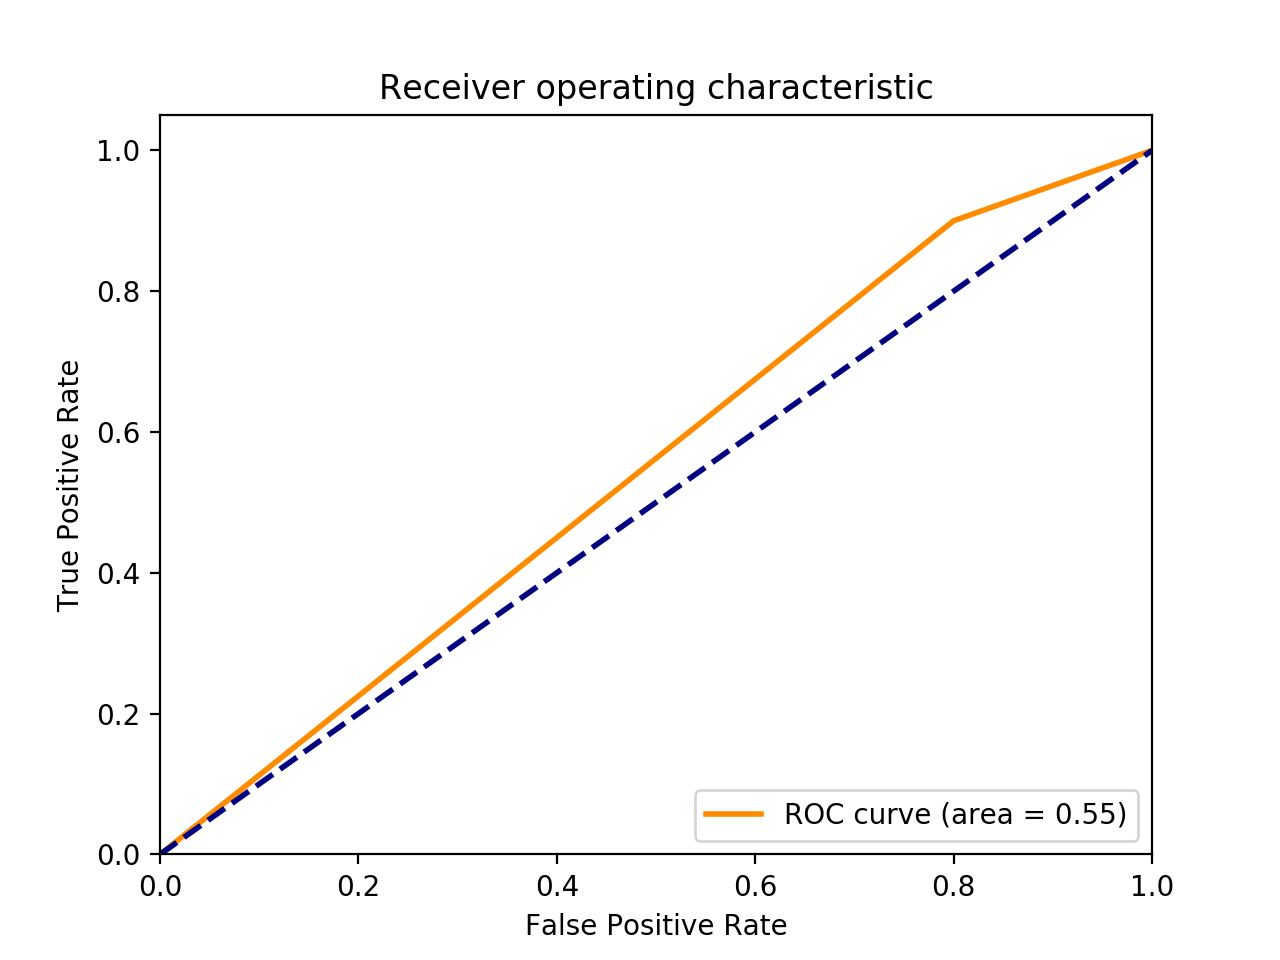

In [111]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# New dataframe where each sentence is a separate document


In [113]:
df_sent = pd.DataFrame(columns=['txt']).astype(str)
for doc in parsed_docs:
    for sent in doc.sents:
        df_sent = df_sent.append({'txt':sent.text}, ignore_index=True)

# Compute vader compund sentiment scores and report top 10 highest- and lowest-sentiment sentences

In [118]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()
best = []
worst = []
TOPELEMS = 10 # top 10 best and worst

for _, row in df_sent.iterrows():
    sent = row.txt
    score = sentiment_analyzer.polarity_scores(sent)['compound']
    if len(best) < TOPELEMS or score > best[-1][0]:
        if len(best) >= TOPELEMS:
            best.pop()
        pos = 0
        for sc, _ in best:
            if sc > score:
                break
            pos += 1
        best.insert(pos, (score, sent))

    if len(worst) < TOPELEMS or score < worst[-1][0]:
        if len(worst) >= TOPELEMS:
            worst.pop()
        pos = len(worst)
        for i in range(len(worst)):
            sc  =  worst[len(worst) - 1- i][0]
            if sc < score:
                break
            pos -= 1
        worst.insert(pos, (score, sent))
               
            
print("BEST")
best.reverse()
print(best)
print('------------------\n')
print("WORST")
print(worst)


BEST
[(0.9821, '(12) That it was solely by reason of the Ballards\' teachings and their embodiment in the "I Am" movement and by reason of the Ballards\' divine power and influence that the United States was saved from destruction; that, by divine inspiration, there had been accorded to the Ballards the ability to maintain the sovereignty and general welfare of the United States; and that, by reason thereof, complete obedience to their teachings, commands and decrees was absolutely necessary for the safety, welfare and sovereignty of the United States and for divine justice to be had in governmental and industrial activities.\n'), (0.0, '518 , brings this manufacturer within the federal power to regulate commerce.\n'), (0.0, '276 , 49 L.Ed.'), (0.0, 'of the manufactured products are sold f. o. b. Richmond, to customers located in states other than Virginia.\n'), (0.0, 'About 83 per cent.'), (0.0, "Practically all the raw materials used are brought from other states into Virginia, where

# Calculate cosine similarity of sentences using tfidf

In [120]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
corpus = list(df_sent['txt'])
corpus_tfidf = vectorizer.fit_transform(corpus)
similarity_matrix = cosine_similarity(corpus_tfidf)

# Find 5 very similar and very dissimilar sentences according to the similarity matrix

In [121]:
NUMBER = 5
similar = []
similar_threshold = 0.50
dissimilar = []
dissimilar_threshold = 0.05

found = 0
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] > similar_threshold:
            print('SIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break
         
            
found = 0         
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] < dissimilar_threshold:
            print('DISSIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break

SIMILAR:
 PER CURIAM.

PER CURIAM.

Score:  1.0

SIMILAR:
About 83 per cent.
To this plan about 96 per cent.
Score:  0.632240677678926

SIMILAR:
276 , 49 L.Ed.
49
Score:  0.5970542910501639

SIMILAR:
Carter v. Carter Coal Co. , 56 S.Ct.
The respondent relies on the decisions of Carter v. Carter Coal Co. , 298 U.S. 238 , 56 S.Ct.
Score:  0.757937029629653

SIMILAR:
855 , 80 L.Ed.
855 , 80 L.Ed.
Score:  1.0

DISSIMILAR:
 PER CURIAM.

The respondent, a Virginia corporation, is a manufacturer of men's clothing with its principal office and its factory in Richmond, Va.

Score:  0.0

DISSIMILAR:
The respondent, a Virginia corporation, is a manufacturer of men's clothing with its principal office and its factory in Richmond, Va.

About 83 per cent.
Score:  0.0

DISSIMILAR:
Practically all the raw materials used are brought from other states into Virginia, where respondent manufactures them into men's clothing.

About 83 per cent.
Score:  0.0

DISSIMILAR:
About 83 per cent.
of the manufactured

# Use k-means clustering to assign the sentences into 20 clusters

In [122]:
from sklearn.cluster import KMeans
NCLUSTERS = 20
# Use tfidf scores for clustering
kmeans = KMeans(n_clusters=NCLUSTERS, random_state=0).fit(corpus_tfidf)

# List 5 example sentences from each cluster


In [123]:
npcorp = np.array(corpus, dtype=str)
for cluster_no in range(1,NCLUSTERS,1):
    print('Cluster {}'.format(cluster_no))
    this_cluster = npcorp[kmeans.labels_ == cluster_no]
    if this_cluster.shape[0] > 5:
        this_cluster = np.random.choice(this_cluster, 5)
    for sent in this_cluster:
        print(sent)

Cluster 1
By so doing, plaintiffs allege, Hughes reduced its labor costs while effectively increasing new employees' wages.

793, 807 ,
29
Spencer's Schuyler plant, which has been closed for more than two years, 591 F.Supp.

That rule is now commonly associated with Clark v. Paul Gray, Inc. , 306 U.S. 583 , 59
Cluster 2
Subsection (c) was added to section 513 :
There was no unconditional right to work forty hours a week at defendant's refinery.

The only matter raised in the second hearing not considered and passed upon both in the administrative hearings and before this court in the original proceeding was the question of Soric's conviction in absentia , shortly after he fled Yugoslavia in 1955, for illicit dealing in foreign commerce and currency.

If a Winters right was available, its extent was uncertain.

A similar question was decided by this court in Silberberg v. Ray Chain Stores, Inc. ,
Cluster 3
Roller v. Cavanaugh , 984 F.2d 120, 124 (4th Cir.), cert.
600 F.3d 624 , 625 (D.C